## Import libraries

In [1]:
!pip3 install mne

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 8.0 MB/s  0:00:01m0:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 11.1 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 3.8 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9/9 [mne]8/9 [mne]lotlib]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from math import ceil


Matplotlib is building the font cache; this may take a moment.


In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/Depression Data/

ModuleNotFoundError: No module named 'google.colab'

## Electrode positions

First, we needed to get positions of electrodes. You can use [mne.channels.make_standard_montage](https://mne.tools/stable/generated/mne.channels.make_standard_montage.html?highlight=mne+channels+make_standard_montage#mne.channels.make_standard_montage) but I had data with 19 electrodes, like in this image:

![10/20 mount](https://www.researchgate.net/profile/Danny-Plass-Oude-Bos/publication/237777779/figure/fig3/AS:669556259434497@1536646060035/10-20-system-of-electrode-placement.png)

So I created my own positions:

In [ ]:
chs = {'FP1': [-0.03, 0.08],
       'FP2': [0.03, 0.08],
       'F7': [-0.073, 0.047],
       'F3': [-0.04, 0.041],
       'Fz': [0, 0.038],
       'F4': [0.04, 0.041],
       'F8': [0.073, 0.047],
       'T3': [-0.085, 0],
       'C3': [-0.045, 0],
       'Cz': [0, 0],
       'C4': [0.045, 0],
       'T4': [0.085, 0],
       'T5': [-0.073, -0.047],
       'P3': [-0.04, -0.041],
       'Pz': [0, -0.038],
       'P4': [0.04, -0.041],
       'T6': [0.07, -0.047],
       'O1': [-0.03, -0.08],
       'O2': [0.03, -0.08]}
channels = pd.DataFrame(chs).transpose()
channels

,0,1
FP1,-0.030,0.080
FP2,0.030,0.080
F7,-0.073,0.047
F3,-0.040,0.041
Fz,0.000,0.038
F4,0.040,0.041
F8,0.073,0.047
T3,-0.085,0.000
C3,-0.045,0.000
Cz,0.000,0.000


This is how it looks:

In [ ]:
# make_dig_montage accepts only 3D coordinates
for key in chs.keys():
    chs[key]+=[0]
chs

{'FP1': [-0.03, 0.08, 0],
 'FP2': [0.03, 0.08, 0],
 'F7': [-0.073, 0.047, 0],
 'F3': [-0.04, 0.041, 0],
 'Fz': [0, 0.038, 0],
 'F4': [0.04, 0.041, 0],
 'F8': [0.073, 0.047, 0],
 'T3': [-0.085, 0, 0],
 'C3': [-0.045, 0, 0],
 'Cz': [0, 0, 0],
 'C4': [0.045, 0, 0],
 'T4': [0.085, 0, 0],
 'T5': [-0.073, -0.047, 0],
 'P3': [-0.04, -0.041, 0],
 'Pz': [0, -0.038, 0],
 'P4': [0.04, -0.041, 0],
 'T6': [0.07, -0.047, 0],
 'O1': [-0.03, -0.08, 0],
 'O2': [0.03, -0.08, 0]}

<ipython-input-6-dd49041d41c7>:2: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mont.plot()


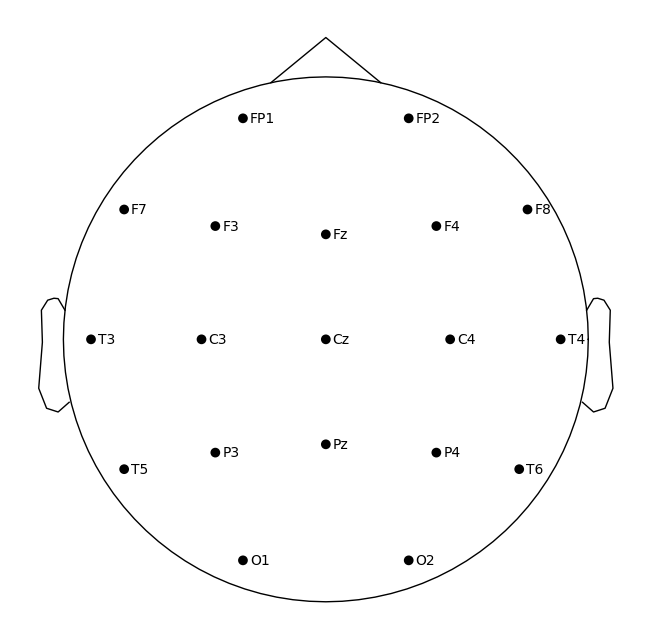

In [ ]:
mont = mne.channels.make_dig_montage(chs)
mont.plot()
plt.show()

## Visualisation function
Here is the crux of this notebook, the functions I wrote to visulize data:

In [ ]:
def plot_eeg(levels, positions, axes, fig, ch_names=None, cmap='Spectral_r', cb_pos=(0.9, 0.1),
             cb_width=0.04, cb_height=0.9, marker=None, marker_style=None, vmin=None, vmax=None, **kwargs):
    """
    Function visulises processed EEG data in a simple way. Based on mne.viz.plot_topomap.


    :param levels: numpy.array, shape (n_chan,)
        data values to plot.
    :param positions: numpy.array, shape (n_chan, 2)|instance of mne.Info
        Location information for the data points(/channels). If an array, for each data point,
        the x and y coordinates. If an Info object, it must contain only one data type and exactly
        len(data) data channels, and the x/y coordinates will be inferred from the montage applied
        to the Info object.
    :param axes: matplotlib.axes.Axes
        The axes to plot to.
    :param fig: matplotlib.figure.Figure
        The figure to create colorbar on.
    :param ch_names: list | None
        List of channel names. If None, channel names are not plotted.
    :param cmap: matplotlib colormap | None
        Colormap to use. If None, ‘Reds’ is used for all positive data, otherwise defaults to ‘RdBu_r’.
        Default value is 'Spectral_r'
    :param cb_pos: tuple/list of floats
        Coordinates of color bar
    :param cb_width: float
        Width of colorbar
    :param cb_height: float
        Height of colorbar
    :param marker: numpy.array of bool, shape (n_channels,) | None
        Array indicating channel(s) to highlight with a distinct plotting style.
        Array elements set to True will be plotted with the parameters given in mask_params.
        Defaults to None, equivalent to an array of all False elements.
    :param marker_style: dict | None
        Additional plotting parameters for plotting significant sensors. Default (None) equals:
        dict(marker='o', markerfacecolor='w', markeredgecolor='k', linewidth=0, markersize=4)
    :param vmin, vmax: float | callable() | None
        Lower and upper bounds of the colormap, in the same units as the data.
        If vmin and vmax are both None, they are set at ± the maximum absolute value
        of the data (yielding a colormap with midpoint at 0). If only one of vmin, vmax is None,
        will use min(data) or max(data), respectively. If callable, should accept a NumPy array
        of data and return a float.
    :param kwargs:
        any other parameter used in mne.viz.plot_topomap
    :return im: matplotlib.image.AxesImage
        The interpolated data.
    :return cn: matplotlib.contour.ContourSet
        The fieldlines.
    """
    if 'mask' not in kwargs:
        mask = np.ones(levels.shape[0], dtype='bool')
    else:
        mask = None
    im, cm = mne.viz.plot_topomap(levels, positions, axes=axes, names=ch_names,
                          cmap=cmap, mask=mask, mask_params=marker_style, show=False, **kwargs)

    cbar_ax = fig.add_axes([cb_pos[0], cb_pos[1], cb_width, cb_height])
    clb = axes.figure.colorbar(im, cax=cbar_ax)
    return im, cm

## Read data

In [ ]:
df = pd.read_csv('EEG.machinelearing_data_BRMH.csv')
df

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,1,M,57.0,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,2,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder,13.425118,11.002916,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,3,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder,29.941780,27.544684,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,4,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder,21.496226,21.846832,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,5,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder,37.775667,33.607679,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,941,M,22.0,2014.8.28,13.0,116.0,Healthy control,Healthy control,41.851823,36.771496,...,82.905657,34.850706,63.970519,63.982003,51.244725,62.203684,62.062237,31.013031,31.183413,98.325230
941,942,M,26.0,2014.9.19,13.0,118.0,Healthy control,Healthy control,18.986856,19.401387,...,65.917918,66.700117,44.756285,49.787513,98.905995,54.021304,93.902401,52.740396,92.807331,56.320868
942,943,M,26.0,2014.9.27,16.0,113.0,Healthy control,Healthy control,28.781317,32.369230,...,61.040959,27.632209,45.552852,33.638817,46.690983,19.382928,41.050717,7.045821,41.962451,19.092111
943,944,M,24.0,2014.9.20,13.0,107.0,Healthy control,Healthy control,19.929100,25.196375,...,99.113664,48.328934,41.248470,28.192238,48.665743,42.007147,28.735945,27.176500,27.529522,20.028446


## Pre-process data for visualization
Even pre-processed data need some processing before visualisation

We need only main.disorder, specific.disorder and absolute power per band per channel (eg. AB.A.delta.a.FP1)

In [ ]:
# One of the columns contains no data, it separates data
# patient info | abs power of PSD per band per channel | sep_col | functional connectivity data
mis = df.isna().sum()
sep_col = mis[mis == df.shape[0]].index[0]
df = df.loc[:, 'main.disorder':sep_col].drop(sep_col, axis=1)
df = df.drop(columns=['main.disorder'])
df

,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,AB.A.delta.g.F8,AB.A.delta.h.T3,AB.A.delta.i.C3,...,AB.F.gamma.j.Cz,AB.F.gamma.k.C4,AB.F.gamma.l.T4,AB.F.gamma.m.T5,AB.F.gamma.n.P3,AB.F.gamma.o.Pz,AB.F.gamma.p.P4,AB.F.gamma.q.T6,AB.F.gamma.r.O1,AB.F.gamma.s.O2
0,Alcohol use disorder,35.998557,21.717375,21.518280,26.825048,26.611516,25.732649,16.563408,29.891368,22.402246,...,1.993727,1.765493,1.464281,1.501948,1.707307,1.553448,1.552658,1.388662,1.592717,1.806598
1,Alcohol use disorder,13.425118,11.002916,11.942516,15.272216,14.151570,12.456034,8.436832,9.975238,14.834740,...,0.903383,0.931967,0.437117,0.930843,1.234874,1.373268,1.411808,1.140695,1.118041,3.162143
2,Alcohol use disorder,29.941780,27.544684,17.150159,23.608960,27.087811,13.541237,16.523963,12.775574,21.686306,...,1.096713,1.691152,1.505663,1.133891,1.661768,1.403429,1.349457,1.270525,1.408471,1.454618
3,Alcohol use disorder,21.496226,21.846832,17.364316,13.833701,14.100954,13.100939,14.613650,8.063191,11.015078,...,1.115040,1.122776,2.128138,1.648217,1.147666,1.049152,1.131654,1.415856,1.391048,1.527403
4,Alcohol use disorder,37.775667,33.607679,21.865556,21.771413,22.854536,21.456377,15.969042,9.434306,15.244523,...,1.193191,2.320845,3.562820,1.441662,1.018804,1.274009,2.350806,2.307730,2.129431,3.766860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,Healthy control,41.851823,36.771496,43.671792,36.860889,24.732236,23.607823,23.288260,7.520642,17.636528,...,1.966436,1.763397,1.285942,2.437923,2.130979,1.727413,1.710518,2.574734,2.533354,5.596057
941,Healthy control,18.986856,19.401387,27.586436,20.194732,19.407491,20.216570,16.465027,13.178851,12.687296,...,2.701922,2.685138,2.648595,2.559590,3.054965,3.163359,3.247100,2.646515,3.385173,3.085049
942,Healthy control,28.781317,32.369230,11.717778,23.134370,26.209302,25.484497,22.586688,11.368466,21.799254,...,3.258838,2.434620,1.501337,0.840513,1.733498,1.610465,1.644675,1.216763,1.614421,1.164097
943,Healthy control,19.929100,25.196375,14.445391,16.453456,16.590649,16.007279,18.909188,13.438102,17.442777,...,1.849005,1.678465,3.655796,1.429330,3.151128,1.630643,1.888551,1.447402,1.819110,1.302056


I want columns to be in format: band.channel

In [ ]:
def reformat_name(name):
    '''
    reformat from XX.X.band.x.channel to band.channel
    '''
    band, _, channel = name[5:].split(sep='.')
    return f'{band}.{channel}'
reformat_vect = np.vectorize(reformat_name)
new_colnames = np.concatenate((df.columns[:2],
                              reformat_vect(df.columns[2:])))
df = df.set_axis(new_colnames, axis=1)
df.columns

Index(['specific.disorder', 'AB.A.delta.a.FP1', 'delta.FP2', 'delta.F7',
       'delta.F3', 'delta.Fz', 'delta.F4', 'delta.F8', 'delta.T3', 'delta.C3',
       ...
       'gamma.Cz', 'gamma.C4', 'gamma.T4', 'gamma.T5', 'gamma.P3', 'gamma.Pz',
       'gamma.P4', 'gamma.T6', 'gamma.O1', 'gamma.O2'],
      dtype='object', length=115)

In [ ]:
print(df)

        specific.disorder  AB.A.delta.a.FP1  delta.FP2   delta.F7   delta.F3  \
0    Alcohol use disorder         35.998557  21.717375  21.518280  26.825048   
1    Alcohol use disorder         13.425118  11.002916  11.942516  15.272216   
2    Alcohol use disorder         29.941780  27.544684  17.150159  23.608960   
3    Alcohol use disorder         21.496226  21.846832  17.364316  13.833701   
4    Alcohol use disorder         37.775667  33.607679  21.865556  21.771413   
..                    ...               ...        ...        ...        ...   
940       Healthy control         41.851823  36.771496  43.671792  36.860889   
941       Healthy control         18.986856  19.401387  27.586436  20.194732   
942       Healthy control         28.781317  32.369230  11.717778  23.134370   
943       Healthy control         19.929100  25.196375  14.445391  16.453456   
944       Healthy control         65.195346  69.241972  35.361363  28.089348   

      delta.Fz   delta.F4   delta.F8   

Calculate mean powers per main.disorder and per specific.disorder and transform form wide to long format:

In [ ]:
# mean powers per main disorder
#main_mean = df.groupby('main.disorder').mean().reset_index()
# mean powers per main disorder
spec_mean = df.groupby('specific.disorder').mean().reset_index()
# list of bands
bands = ['delta', 'theta', 'alpha', 'beta', 'highbeta', 'gamma']
# convert from wide to long
#main_mean = pd.wide_to_long(main_mean, bands, ['main.disorder'], 'channel', sep='.', suffix='\w+')
spec_mean = pd.wide_to_long(spec_mean, bands, ['specific.disorder'], 'channel', sep='.', suffix='\w+')
spec_mean

,,AB.A.delta.a.FP1,delta,theta,alpha,beta,highbeta,gamma
specific.disorder,channel,,,,,,,
Acute stress disorder,FP2,21.010092,21.610872,21.035088,29.272522,14.903953,2.485280,2.651323
Adjustment disorder,FP2,22.409204,25.012049,16.321677,28.243323,12.652463,2.615558,3.455320
Alcohol use disorder,FP2,19.031935,18.716010,14.593633,32.040537,12.248777,2.096053,2.225944
Behavioral addiction disorder,FP2,18.631096,19.062980,13.529733,17.076794,9.572497,2.201521,2.808698
Bipolar disorder,FP2,20.920267,21.376145,13.508988,23.131361,13.852397,2.754371,3.564100
...,...,...,...,...,...,...,...,...
Obsessive compulsitve disorder,FP1,18.261254,NaN,12.469764,24.380553,9.946188,2.199657,3.096013
Panic disorder,FP1,18.514396,NaN,10.981395,19.364866,11.332534,2.346333,2.780458
Posttraumatic stress disorder,FP1,22.263038,NaN,15.208669,24.545891,14.327015,2.697516,3.475643


## Visualization
We came to the crux of this notebook, visualisations. First, I visualise just one case:

In [ ]:
spec_mean.loc['Depressive disorder', 'gamma']

channel
FP2    3.337612
F7     3.111416
F3     3.371949
Fz     3.110496
F4     3.178877
F8     3.285425
T3     3.298375
C3     3.062197
Cz     2.926890
C4     3.047236
T4     2.874408
T5     2.339983
P3     2.539246
Pz     2.534559
P4     2.557899
T6     2.522967
O1     3.696353
O2     3.425693
FP1    3.277635
Name: gamma, dtype: float64

In [ ]:
# extract power for one main.disorder and one band
test =  spec_mean.loc['Depressive disorder', 'gamma']
test.sort_index(inplace=True)
channels.sort_index(inplace=True)
print(test.index)
print(channels.index)

Index(['C3', 'C4', 'Cz', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'Fz', 'O1',
       'O2', 'P3', 'P4', 'Pz', 'T3', 'T4', 'T5', 'T6'],
      dtype='object', name='channel')
Index(['C3', 'C4', 'Cz', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'Fz', 'O1',
       'O2', 'P3', 'P4', 'Pz', 'T3', 'T4', 'T5', 'T6'],
      dtype='object')


<ipython-input-14-9ea1a28e36da>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.sort_index(inplace=True)


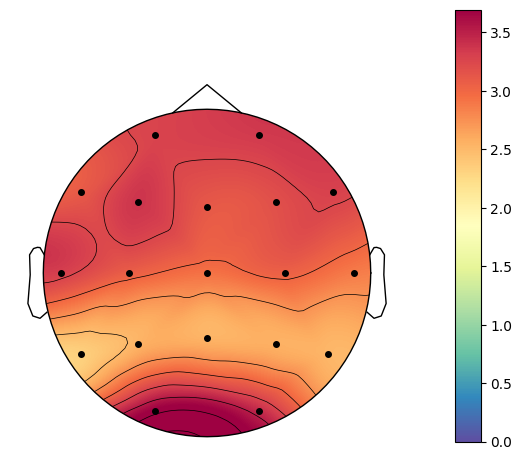

In [ ]:


# make sure that channels are in correct order
assert (test.index == channels.index).all()
# plot
fig, ax = plt.subplots()
plot_eeg(test, channels.to_numpy(), ax, fig, vmin=0, marker_style={'markersize':4, 'markerfacecolor':'black'})
plt.show()

Now, a more complex visualisation:

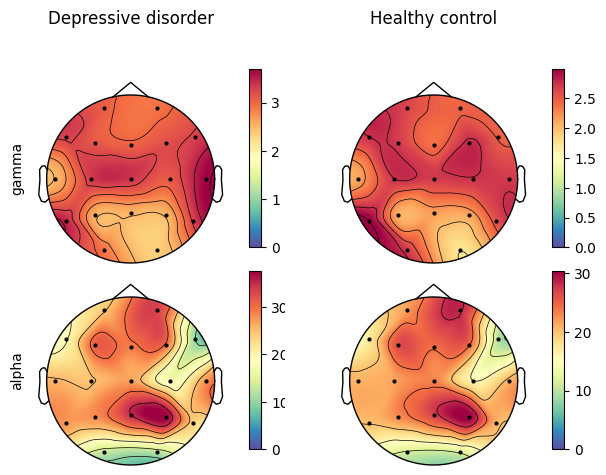

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(6, 4))
test2 = [
     spec_mean.loc['Depressive disorder', 'gamma'],
     spec_mean.loc['Healthy control', 'gamma'],
     spec_mean.loc['Depressive disorder', 'alpha'],
     spec_mean.loc['Healthy control', 'alpha'],
]
subfigs = fig.subfigures(2,2)
for subfig, test1 in zip(subfigs.flatten(), test2):
    ax = subfig.subplots()
    plot_eeg(test1, channels.to_numpy(), ax, subfig, vmin=0, marker_style={'markersize':2, 'markerfacecolor':'black'})
subfigs[0, 0].suptitle('Depressive disorder', y=1.3)
subfigs[0, 1].suptitle('Healthy control', y=1.3)
subfigs[0, 0].axes[0].set_ylabel('gamma')
subfigs[1, 0].axes[0].set_ylabel('alpha')
subfigs[0, 1].axes[0].set_ylabel(' ')
subfigs[1, 1].axes[0].set_ylabel(' ')
plt.show()

Finally, visualisation of whole dataset!
Helper function for visualisation.

In [ ]:
def plot_eeg_dataset(dataset, channels, gwidth=2, gheight=1.5, wspace=0,
                     marker_style={'markersize': 2, 'markerfacecolor': 'black'},
                     band_ordered=None, conditions_ordered=None, band_labels=None,
                     condition_labels=None, **kwargs):
    """
    Visualisation of pre-processed EEG dataset.
    See example of usage on Kaggle (https://www.kaggle.com/code/lazygene/visualising-pre-processed-eeg-data)
    :param dataset: pandas.DataFrame
        Data set to visualise. See format of the dataset on Kaggle (url above).
    :param channels: pandas.DataFrame
        Channel (index) names and positions (columns: x and y).
    :param gwidth: float
        Width of single topology map.
    :param gheight: float
        Height of single topology map.
    :param wspace: float
        Space between subplots
    :param marker_style:
        marker_style: dict
        Additional plotting parameters for plotting significant sensors. Default (None) equals:
        dict(marker='o', markerfacecolor='black', markeredgecolor='k', linewidth=0, markersize=2)
    :param band_ordered: list | None
        List of EEG bands (e.g. delta, gamma, etc.), they must be one or more columns of dataset DataFrame.
        Provides a way to control the order (form top to bottom) of bands in the resulted complex figure.
        If None, all columns of dataset are used in orfer of columns.
    :param conditions_ordered: list | None
        List of conditions, they must be one or more level 0 indecies of dataset DataFrame.
        Provides a way to control the order (from left to right) of conditions in the resulted complex figure.
        If None, all unique 0 level indecies of dataset are used in order they are in the dataset.
    :param band_labels: list | None
        List of custom labels for EEG bands, it must be the same length as band_ordered.
        If None, column names of dataset DataFrame are used.
    :param condition_labels:
        List of custom labels for conditions, it must be the same length as conditions_ordered.
        If None, original indecies' names of dataset DataFrame are used.
    :param kwargs:
        any other parameter used in plot_eeg
    :return: fig: matplotlib.figure.Figure
    :return: subfigs: np.array of matplotlib.figure.Figure elements
    """
    if band_ordered is None:
        band_ordered = dataset.columns
    if conditions_ordered is None:
        conditions_ordered = dataset.index.get_level_values(0).unique()
    if band_labels is None:
        band_labels = band_ordered
    if condition_labels is None:
        condition_labels = conditions_ordered
    # number of rows in figure
    nrows = len(band_ordered)
    # number of columns in figure
    ncols = len(conditions_ordered)
    # create figure with width gwidth and gheight per graph
    fig = plt.figure(constrained_layout=True, figsize=(gwidth*ncols, gheight*nrows))
    # create subfigures
    subfigs = fig.subfigures(nrows, ncols, wspace=wspace)
    # loop through subfigures
    for ind, subfig in np.ndenumerate(subfigs):
        i, j = ind
        # select band (column name in main_mean)
        band = band_ordered[i]
        # select disorder (row name in main_mean)
        disorder = conditions_ordered[j]
        # select band levels for disorder
        levels = dataset.loc[disorder, band]
        # calculate maximum (vmax) for easier comparison between disorders
        vmax = ceil(max(dataset[band]))
        # create axes
        ax = subfig.subplots()
        # plot eeg
        plot_eeg(levels, channels.to_numpy(), ax, subfig, vmin=0, vmax=vmax, marker_style=marker_style, **kwargs)
        # annotate band (if needed)
        if j == 0:
            ax.set_ylabel(band_labels[i])
        # annotate disorder (if needed)
        if i == 0:
            subfig.suptitle(condition_labels[j], y=1.3)
    return fig, subfigs

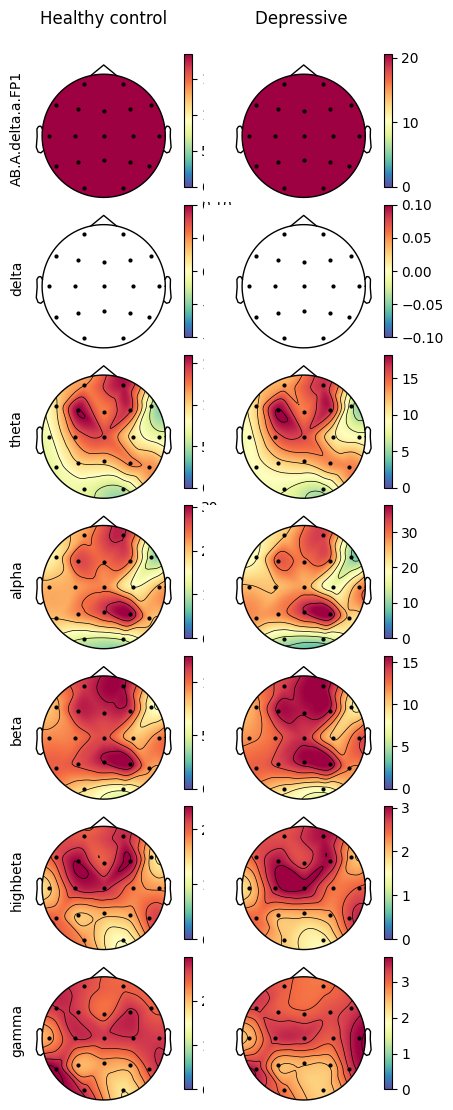

In [ ]:
# order conditions (main.disorder)
conds = ['Healthy control',
         'Depressive disorder']
conds_labs = [x.replace('disorder', '') for x in conds]
plot_eeg_dataset(spec_mean, channels, conditions_ordered=conds, condition_labels=conds_labs)
plt.show()

Second Part: Machine Learning

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.5 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import pickle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from copy import deepcopy
from tqdm import tqdm

In [ ]:
df = pd.read_csv('EEG.machinelearing_data_BRMH.csv')
df.head()

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,1,M,57.0,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,2,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder,13.425118,11.002916,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,3,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder,29.941780,27.544684,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,4,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder,21.496226,21.846832,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,5,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder,37.775667,33.607679,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662


In [ ]:
# function to rename
def reformat_name(name):
    '''
    reformat from XX.X.band.x.channel to band.channel or
    COH.X.band.x.channel1.x.channel2 to COH.band.channel1.channel2
    '''
    splitted = name.split(sep='.')
    if len(splitted) < 5:
        return name
    if splitted[0] != 'COH':
        result = f'{splitted[2]}.{splitted[4]}'
    else:
        result = f'{splitted[0]}.{splitted[2]}.{splitted[4]}.{splitted[6]}'
    return result
# rename columns
df.rename(reformat_name, axis=1, inplace=True)
df

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,delta.FP1,delta.FP2,...,COH.gamma.Pz.P4,COH.gamma.Pz.T6,COH.gamma.Pz.O1,COH.gamma.Pz.O2,COH.gamma.P4.T6,COH.gamma.P4.O1,COH.gamma.P4.O2,COH.gamma.T6.O1,COH.gamma.T6.O2,COH.gamma.O1.O2
0,1,M,57.0,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,2,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder,13.425118,11.002916,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,3,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder,29.941780,27.544684,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,4,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder,21.496226,21.846832,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,5,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder,37.775667,33.607679,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,941,M,22.0,2014.8.28,13.0,116.0,Healthy control,Healthy control,41.851823,36.771496,...,82.905657,34.850706,63.970519,63.982003,51.244725,62.203684,62.062237,31.013031,31.183413,98.325230
941,942,M,26.0,2014.9.19,13.0,118.0,Healthy control,Healthy control,18.986856,19.401387,...,65.917918,66.700117,44.756285,49.787513,98.905995,54.021304,93.902401,52.740396,92.807331,56.320868
942,943,M,26.0,2014.9.27,16.0,113.0,Healthy control,Healthy control,28.781317,32.369230,...,61.040959,27.632209,45.552852,33.638817,46.690983,19.382928,41.050717,7.045821,41.962451,19.092111
943,944,M,24.0,2014.9.20,13.0,107.0,Healthy control,Healthy control,19.929100,25.196375,...,99.113664,48.328934,41.248470,28.192238,48.665743,42.007147,28.735945,27.176500,27.529522,20.028446


In [ ]:
typo_ind = df[df['specific.disorder'] == 'Obsessive compulsitve disorder'].index
df.loc[typo_ind, 'specific.disorder'] = 'Obsessive compulsive disorder'

In [ ]:
missing = df.isna().sum()
sep_col = missing[missing == df.shape[0]].index[0]
sep_col

'Unnamed: 122'

In [ ]:
missing[missing > 0]

education        15
IQ               13
Unnamed: 122    945
dtype: int64

In [ ]:
educ_na = df[df['education'].isna()]
iq_na = df[df['IQ'].isna()]
educ_iq_na = pd.concat([educ_na, iq_na]).drop_duplicates()
educ_iq_na

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,delta.FP1,delta.FP2,...,COH.gamma.Pz.P4,COH.gamma.Pz.T6,COH.gamma.Pz.O1,COH.gamma.Pz.O2,COH.gamma.P4.T6,COH.gamma.P4.O1,COH.gamma.P4.O2,COH.gamma.T6.O1,COH.gamma.T6.O2,COH.gamma.O1.O2
0,1,M,57.00,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
17,18,M,30.00,2013.9.27,NaN,86.0,Addictive disorder,Alcohol use disorder,12.443237,12.503703,...,85.080600,53.533875,62.817411,68.040950,71.834549,48.779049,80.516443,22.049743,76.277261,45.629506
21,22,M,20.00,2014.10.23,NaN,116.0,Addictive disorder,Alcohol use disorder,28.287190,22.412264,...,33.065475,24.351780,18.764173,32.610337,38.451805,20.933501,48.626712,16.258394,40.471735,24.175359
155,156,M,18.00,2013.12.7,NaN,103.0,Addictive disorder,Behavioral addiction disorder,16.548803,19.042179,...,93.825121,79.091595,83.132315,88.900783,87.508591,76.257681,89.811513,62.739950,84.729816,86.322844
173,174,M,23.00,2015.11.14,NaN,113.0,Healthy control,Healthy control,19.050158,23.277470,...,68.005720,54.685472,70.694110,62.676608,67.705314,46.667642,66.673782,29.689482,74.787580,51.039538
269,270,M,25.00,2015.9.23,NaN,85.0,Obsessive compulsive disorder,Obsessive compulsive disorder,6.186264,7.112847,...,72.743284,63.723838,61.257858,67.473157,77.664778,57.967084,73.898719,59.775191,81.941728,72.195171
270,271,M,34.00,2015.9.21,NaN,120.0,Obsessive compulsive disorder,Obsessive compulsive disorder,12.784872,15.922964,...,72.409132,49.265064,41.222401,68.010480,72.429188,26.188907,68.653874,18.072318,63.285321,41.822238
279,280,M,35.00,2016.6.2,NaN,NaN,Obsessive compulsive disorder,Obsessive compulsive disorder,21.524573,22.227615,...,90.934877,93.568209,94.185299,92.271775,96.445879,91.470862,96.851513,92.296182,96.209585,96.660561
280,281,M,37.00,2016.6.27,NaN,110.0,Obsessive compulsive disorder,Obsessive compulsive disorder,11.971083,11.374465,...,91.150863,78.359575,64.861521,74.389105,89.863923,50.322649,75.469583,49.440177,84.022887,69.921675
281,282,M,22.00,2016.6.30,NaN,107.0,Obsessive compulsive disorder,Obsessive compulsive disorder,12.516343,10.136242,...,96.419647,77.360976,95.156801,96.105427,87.746498,94.760227,97.579921,81.495805,86.770154,98.121870


In [ ]:
drop_md = educ_iq_na['main.disorder'].value_counts().sort_index()
all_md = df['main.disorder'].value_counts().sort_index()[drop_md.index]
pd.concat([all_md, drop_md/all_md * 100], axis=1).set_axis(['all_data', 'na_percentage'], axis=1).sort_values('na_percentage', ascending=False)

,all_data,na_percentage
main.disorder,,
Obsessive compulsive disorder,46,13.043478
Addictive disorder,186,4.301075
Trauma and stress related disorder,128,3.906250
Healthy control,95,2.105263
Mood disorder,266,1.503759
Anxiety disorder,107,0.934579


In [ ]:
display(df[['education', 'IQ']].agg(['mean', 'median']))
imputer = SimpleImputer(strategy='median')

,education,IQ
mean,13.43871,101.580472
median,13.00000,102.000000


In [ ]:
# drop columns we don't need
X = df.drop([sep_col, 'no.', 'eeg.date'], axis=1).copy(deep=True)
# target and categorical columns
target_col = ['main.disorder', 'specific.disorder']
cat_col = ['sex', 'main.disorder','specific.disorder']
# unique disorders
md_unique = df['main.disorder'].unique()
sd_unique = df['specific.disorder'].unique()
# make sure that healthy control is encoded as zero
hc = 'Healthy control'
# lists of disorders without healthy control
md = md_unique[md_unique != hc]
sd = sd_unique[sd_unique != hc]
md_ord = np.insert(md, 0, hc)
sd_ord = np.insert(sd, 0, hc)
sex_ord = df['sex'].unique()
# encoder for targets and sex
enc = OrdinalEncoder(categories=[sex_ord, md_ord, sd_ord])
X[cat_col] = enc.fit_transform(X[cat_col])
# save targets
md_target = X['main.disorder']
sd_target = X['specific.disorder']
# drop targets
X.drop(target_col, axis=1, inplace=True)
# fill missing data
mv_cols = ['education', 'IQ']
X[mv_cols] = imputer.fit_transform(X[mv_cols])
# numerical columns for log-transformation
logtrans_cols = X.drop(['sex', 'education', 'IQ'], axis=1).columns
X[logtrans_cols] = np.log(X[logtrans_cols])

def sep_to_bin(features, target, target_ord, disorders, hc_id=0):
    assert len(features) == len(target)
    X = dict()
    Y = dict()
    for disorder in disorders:
        # find how target was coded
        disorder_id = np.where(target_ord == disorder)[0][0]
        # extract targets
        y = target[target.isin([hc_id, disorder_id])]
        y[y != hc_id] = 1
        # features
        x = features.loc[y.index]
        # save
        X[disorder] = x
        Y[disorder] = y
    return X, Y

def min_validation(features, target_name, disorders, hc_name='Healthy control'):
    # count number of rows per each target value
    counts = df[target_name].value_counts()
    # initialize result
    result = np.zeros(len(disorders), dtype='bool')
    for i, disorder in enumerate(disorders):
        # calculate size of dataset: disorder + healthy control
        hc_disorder_count = counts[hc_name] + counts[disorder]
        # update result
        result[i] = len(features[disorder]) == hc_disorder_count
    return result

# separate to binary classification subsets
Xmd, Ymd = sep_to_bin(X, md_target, md_ord, md)
Xsd, Ysd = sep_to_bin(X, sd_target, sd_ord, sd)

# validate length of subsets
assert min_validation(Xmd, 'main.disorder', md).all()
assert min_validation(Xsd, 'specific.disorder', sd).all()

In [ ]:
def lists_to_dict (keys, items):
    return {key: item for key,item in zip(keys, items)}

# models names
model_names = ['EN', 'SVM', 'RF', 'XGB', 'LGBM', 'CatBoost']
# param grids for gridsearch
param_grids = [
    {
        'l1_ratio': np.linspace(0, 1, 5),
        'C': [0.5, 1, 5, 10]
    },
    {
        'C': [0.5, 1, 5, 10]
    },
    {
        'n_estimators': [100, 300, 500],
        'max_depth': [1, 3, 6, None]
    },
    {
        'n_estimators': [100, 300, 500],
        'subsample': [0.3, 0.5, 1],
        'max_depth': [1, 3, 6, None]
    },
    {
        'n_estimators': [100, 300, 500],
        'subsample': [0.3, 0.5, 1],
        'max_depth': [1, 3, 6, None]
    },
    {
        'n_estimators': [100, 300, 500],
        'max_depth': [1, 3, 6, None],

    }
]
param_grids = lists_to_dict(model_names, param_grids)

# models for gridsearch
models = [
    LogisticRegression(penalty='elasticnet', solver='saga'),
    SVC(kernel='linear', random_state=77),
    RandomForestClassifier(random_state=77),
    XGBClassifier(),#tree_method='gpu_hist'),
    LGBMClassifier(random_state=77), #device='gpu'),
    CatBoostClassifier(random_seed=77,logging_level='Silent')#,task_type='GPU')
]
models = lists_to_dict(model_names, models)

In [ ]:
def n_best (gs_res, n=1):
    """Returns nth best estimator parameters, mean score and std of it"""
    print(gs_res)
    mu=[]
    std=[]
    params=[]
    scores = ["accuracy","precision","f1","recall","roc_auc"]
    for i in scores:
      ind = np.where(gs_res['rank_test_' + i] == n)[0][0]
      mu.append(gs_res["mean_test_"+ i][ind])
      std.append(gs_res["std_test_"+ i][ind])
      params.append(i)
      #params.append(gs_res["params"][ind])
    return params, mu, std

def cache_mkdir(cache, directory, root_dir='.'):
    """Create directory and return path to it"""
    directory = directory.replace(' ', '_')
    path = os.path.join(root_dir, directory)
    if cache and not os.path.exists(path):
        os.makedirs(path)
    return path

def read_cache(cache, path, silent=False):
    """Read from cache file"""
    result = None
    if cache and os.path.exists(path):
        with open(path, 'rb') as file:
            if not silent:
                print(f'Extracted from cache ({path})')
            result = pickle.load(file)
    return result

def write_cache(cache, obj, path):
    """Write to cache"""
    if cache:
        with open(path, 'wb') as file:
            pickle.dump(obj, file)

def grid_search(disorders, models, params, Xs, Ys, random_seed=None, cache=True, cache_dir='grid_search', feature_list=None, silent=False):
    # result dict
    result = []
    # set feature list if None
    if feature_list is None:
        feature_list = X.columns
    # create cache directory if needed
    cache_mkdir(cache, cache_dir)
    for disorder in disorders:
        # get and create (if needed) a disorder cache directory
        disorder_folder = cache_mkdir(cache, disorder, cache_dir)
        for key in models.keys():
            print(disorder, key)
            # get cache file path
            cache_file = os.path.join(disorder_folder, key)
           # read file from cache
            res = read_cache(cache, cache_file, silent)
            if res is None:
                res = {}
                res['disorder'] = disorder
                res['algorithm'] = key
                # set seed
                if random_seed is not None:
                    np.random.seed(random_seed)
                # scale
                scaler = StandardScaler()
                x = scaler.fit_transform(Xs[disorder][feature_list])
                # gridsearch
                gs = GridSearchCV(models[key], params[key], cv=10, scoring=['accuracy','f1','precision', 'recall', 'roc_auc'], n_jobs=-1, verbose=1, refit='roc_auc').fit(x, Ys[disorder]) #'accuracy','balanced_accuracy','top_k_accuracy','f1','precision', 'recall', roc_auc'
                # best estimator parameters, cross validation mean score and score std
                res['params'], res['mean_score'], res['std_score'] = n_best(gs.cv_results_)
                # save cv_results_
                res['cv_result'] = deepcopy(gs.cv_results_)
                # cache results
                write_cache(cache, res, cache_file)
            result.append(res)
    return result

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
print(sd)
sd = ['Depressive disorder'] #only pick depressive
print(sd)

['Depressive disorder']
['Depressive disorder']


In [ ]:
sd_res_dict = grid_search(sd, models, param_grids, Xsd, Ysd, 77)

Depressive disorder EN
Extracted from cache (grid_search/Depressive_disorder/EN)
Depressive disorder SVM
Extracted from cache (grid_search/Depressive_disorder/SVM)
Depressive disorder RF
Extracted from cache (grid_search/Depressive_disorder/RF)
Depressive disorder XGB
Extracted from cache (grid_search/Depressive_disorder/XGB)
Depressive disorder LGBM
Fitting 10 folds for each of 36 candidates, totalling 360 fits
[LightGBM] [Info] Number of positive: 199, number of negative: 95
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 112944
[LightGBM] [Info] Number of data points in the train set: 294, number of used features: 1144
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.676871 -> initscore=0.739428
[LightGBM] [Info] Start training from score 0.739428
{'mean_fit_time': array([0.86383498, 0.67782471, 0.489238  , 1.19457374, 2.26157932,
       2.0

In [ ]:
sd_results = pd.DataFrame(sd_res_dict)

sd_results.to_csv('sd_results.csv')
sd_results #accuracy

,disorder,algorithm,params,mean_score,std_score,cv_result
0,Depressive disorder,EN,"[accuracy, precision, f1, recall, roc_auc]","[0.7427586206896553, 0.8423283415930474, 0.791...","[0.1341993280087389, 0.09697523992305385, 0.11...","{'mean_fit_time': [0.8709078311920166, 0.96077..."
1,Depressive disorder,SVM,"[accuracy, precision, f1, recall, roc_auc]","[0.7285057471264368, 0.7902393684746626, 0.795...","[0.10235798368416069, 0.05990774598182246, 0.0...","{'mean_fit_time': [0.05344457626342773, 0.0453..."
2,Depressive disorder,RF,"[accuracy, precision, f1, recall, roc_auc]","[0.7320689655172414, 0.7493951885473626, 0.819...","[0.08579279853588127, 0.05859307995270639, 0.0...","{'mean_fit_time': [0.4961609125137329, 1.17115..."
3,Depressive disorder,XGB,"[accuracy, precision, f1, recall, roc_auc]","[0.7903448275862069, 0.8085034965034964, 0.855...","[0.11355274743480843, 0.10831244661731841, 0.0...","{'mean_fit_time': [1.6950806856155396, 1.25126..."
4,Depressive disorder,LGBM,"[accuracy, precision, f1, recall, roc_auc]","[0.78, 0.8133962970667776, 0.843760090668769, ...","[0.10812567371301683, 0.08235861741853426, 0.0...","{'mean_fit_time': [0.8638349771499634, 0.67782..."
5,Depressive disorder,CatBoost,"[accuracy, precision, f1, recall, roc_auc]","[0.7762068965517241, 0.7800305958132046, 0.851...","[0.08050745713276103, 0.06773020423015631, 0.0...","{'mean_fit_time': [5.0217393159866335, 13.5621..."


In [ ]:
algo_list = [i for i in sd_results['algorithm']]
mean_results = [i for i in sd_results['mean_score']]
std_results = [i for i in sd_results['std_score']]
results = []
print(algo_list)
print(mean_results)
print(std_results)
for i in range (len(algo_list)):
  temp = [algo_list[i]]
  for j in mean_results[i]:
      temp.append(j)
  for k in std_results[i]:
      temp.append(k)
  results.append(temp)

print(results)
param_list = ["ML"]
for i in sd_results['params'][0]:
  param_list.append(i)
for i in sd_results['params'][0]:
  param_list.append(i+" std_score")
print(param_list)



['EN', 'SVM', 'RF', 'XGB', 'LGBM', 'CatBoost']
[[0.7427586206896553, 0.8423283415930474, 0.7916505712450739, 0.7578947368421053, 0.8081461988304094], [0.7285057471264368, 0.7902393684746626, 0.7953959012110489, 0.8078947368421053, 0.7647280701754385], [0.7320689655172414, 0.7493951885473626, 0.8193343754217084, 0.9947368421052631, 0.7852836257309941], [0.7903448275862069, 0.8085034965034964, 0.855355399293086, 0.9144736842105263, 0.8256959064327486], [0.78, 0.8133962970667776, 0.843760090668769, 0.9142105263157895, 0.834704678362573], [0.7762068965517241, 0.7800305958132046, 0.8510446739391598, 0.9744736842105264, 0.8202748538011697]]
[[0.1341993280087389, 0.09697523992305385, 0.11892854899352609, 0.15528545780980976, 0.1445214483287898], [0.10235798368416069, 0.05990774598182246, 0.08944248341050152, 0.1372009465090955, 0.149784845096083], [0.08579279853588127, 0.05859307995270639, 0.058210780997689525, 0.01578947368421054, 0.14031052359083448], [0.11355274743480843, 0.108312446617318

In [ ]:
df = pd.DataFrame(results, columns=param_list)

# print dataframe.
print(df)

         ML  accuracy  precision        f1    recall   roc_auc  \
0        EN  0.742759   0.842328  0.791651  0.757895  0.808146   
1       SVM  0.728506   0.790239  0.795396  0.807895  0.764728   
2        RF  0.732069   0.749395  0.819334  0.994737  0.785284   
3       XGB  0.790345   0.808503  0.855355  0.914474  0.825696   
4      LGBM  0.780000   0.813396  0.843760  0.914211  0.834705   
5  CatBoost  0.776207   0.780031  0.851045  0.974474  0.820275   

   accuracy std_score  precision std_score  f1 std_score  recall std_score  \
0            0.134199             0.096975      0.118929          0.155285   
1            0.102358             0.059908      0.089442          0.137201   
2            0.085793             0.058593      0.058211          0.015789   
3            0.113553             0.108312      0.079709          0.083924   
4            0.108126             0.082359      0.076029          0.068068   
5            0.080507             0.067730      0.052092          0.0